In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

2022-01-31 23:44:21.939625: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Load data

In [2]:
def _load_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return data

def load_results_to_df(json_results_patern):
    json_files = tf.io.gfile.glob(json_results_patern)
    
    results = [_load_json(jfile) for jfile in json_files]

    return pd.DataFrame(results)

In [3]:
def format_results(df):
    df = df[['training_setup', 'dataset', 'model', 'f1_score_cls', 'acc_all', 'acc_bins']]
    
    return pd.concat([df.drop(['acc_bins'], axis=1),
                      df['acc_bins'].apply(pd.Series).add_prefix('acc_bin_')],
                     axis=1)

In [4]:
def _load_metadata(dataset_json, category_map, default_empty_label=0):
    with tf.io.gfile.GFile(dataset_json, 'r') as json_file:
        json_data = json.load(json_file)
    images = pd.DataFrame(json_data['images'])
    if 'annotations' in json_data.keys():
        annotations = pd.DataFrame(json_data['annotations'])
        images = pd.merge(images,
                        annotations[["image_id", "category_id"]],
                        how='left',
                        left_on='id',
                        right_on='image_id')
    else:
        images['category_id'] = default_empty_label

    images['category_id'] = images['category_id'].apply(
                                          category_map.category_to_index)

    return images

In [5]:
class CategoryMap:
  def __init__(self, dataset_json):
    with open(dataset_json) as json_file:
      data = json.load(json_file)

    category2idx = {}
    idx2category = {}
    category2name = {}
    category_list = []

    categories = pd.DataFrame(data['annotations'])['category_id'].unique()
    categories = sorted(categories)
    for idx, category in enumerate(categories):
      category2idx[category] = idx
      idx2category[idx] = category
      category_list.append(category)

    category2name = {cat['id']: cat['name'] for cat in data['categories']
                      if cat['id'] in category_list}

    self.category2idx = category2idx
    self.idx2category = idx2category
    self.category2name = category2name
    self.num_classes = len(self.category2idx)
    self.category_list = category_list

  def category_to_index(self, category):
    return self.category2idx[category]

  def index_to_category(self, index):
    return self.idx2category[index]

  def category_to_name(self, category):
    return self.category2name[category]

  def get_category_list(self):
    return self.category_list

  def get_num_classes(self):
    return self.num_classes

In [6]:
def load_instances_per_class(json_data):
    category_map = CategoryMap(json_data)
    metadata = _load_metadata(json_data, category_map)
    instances_per_cls = dict(metadata['category_id'].value_counts())

    return instances_per_cls

In [7]:
results_json = '/data/fagner/training/bags_paper/results/exp1/*_results.json'

In [8]:
results = load_results_to_df(results_json)
results = format_results(results)

### Plot

In [9]:
bins_titles = [('acc_bin_4', 'N ≥ 1000'),
               ('acc_bin_3', '100 ≤ N < 1000'),
               ('acc_bin_2', '10 ≤ N < 100'),
               ('acc_bin_1', 'N < 10'),
               ('acc_all', 'All')]

In [10]:
def check_nan_bins(results_df):
    sel_titles = []
    
    for bin_t in bins_titles:
        if not results_df[bin_t[0]].isnull().values.any():
            sel_titles.append(bin_t)

    return sel_titles

In [11]:
def plot_acc(df, column, title, ax):
    training_setup_sort = {'repre': 0, 'crt': 1, 'cbfocal': 2, 'bags': 3}
    training_setup_name = {'repre': 'Joint', 'crt': 'cRT', 'cbfocal': 'CBFocal', 'bags': 'BAGS'}
    df = df.sort_values(by=['training_setup'], key=lambda x: x.map(training_setup_sort))
    df['training_setup'] = df['training_setup'].map(training_setup_name)
    for model, marker in zip(['mbnetv3', 'swin-s', 'effv2b2', 'resnet50'], ['o', '^', 's', 'D']):
        data = df[df.model==model]
        ax.plot(data['training_setup'], data[column], marker=marker, label=model, markersize=8)
    ax.set_title(title)

In [12]:
def plot_all_bins_acc(results_df):
    sel_bins_titles = check_nan_bins(results_df)
    fig, axs = plt.subplots(1, len(sel_bins_titles),figsize=(len(sel_bins_titles)*2.7,2.5))
    fig.tight_layout()
    axs[0].set(ylabel='Accuracy')
    for i, bin_t in enumerate(sel_bins_titles):
        plot_acc(results_df, bin_t[0], bin_t[1], axs[i])

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.25), prop={'size': 12})
    plt.show()

In [13]:
def get_group(instances_count, max_groups):
    for group, group_max in enumerate(max_groups):
        if instances_count < group_max:
            return group
    return 0

In [14]:
def plot_f1(results_df, instances_per_cls, model, train_setup, train_ref):
    data = results_df[(results_df.model==model)&(results_df.training_setup==train_setup)]
    data_reference = results_df[(results_df.model==model)&(results_df.training_setup==train_ref)]
    
    df = pd.DataFrame({'class_id': range(len(data['f1_score_cls'].iloc[0])),
                       'data': data['f1_score_cls'].iloc[0],
                       'data_reference': data_reference['f1_score_cls'].iloc[0]})
    df['class_count'] = df['class_id'].map(instances_per_cls)
    df = df.sort_values(by=['class_count'], ascending=False)
    df['seq'] = range(len(df))
    df['group'] = df['class_count'].apply(lambda x: get_group(x, [0, 10, 100, 1000, 2**100]))

    for group, color, legend in zip(range(1, 5),
                                    ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple'],
                                    ['N < 10', '10 ≤ N < 100', '100 ≤ N < 1000', 'N ≥ 1000']):
        df_sel = df[df.group==group]
        if len(df_sel) > 0:
            plt.bar(df_sel.seq, df_sel.data - df_sel.data_reference, color=color, label=legend)

    plt.legend()
    plt.title("%s: %s" % (model, train_setup))
    plt.show()

### WCS

In [15]:
wcs_results = results[results.dataset=='wcs']
wcs_instances_per_cls = load_instances_per_class('/data/fagner/training/bags_paper/data/wcs_images_20211210ufam_train.json')

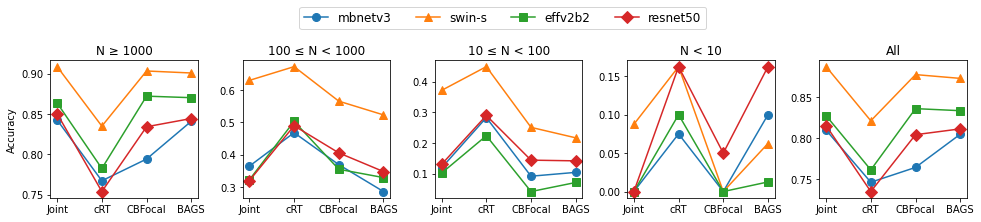

In [16]:
plot_all_bins_acc(wcs_results)

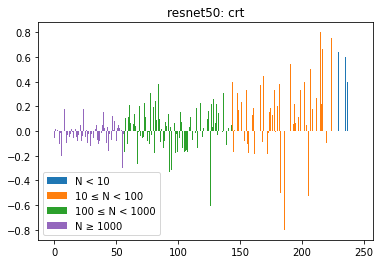

In [17]:
plot_f1(wcs_results, wcs_instances_per_cls, 'resnet50', 'crt', 'repre')

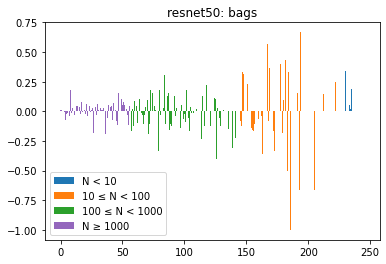

In [18]:
plot_f1(wcs_results, wcs_instances_per_cls, 'resnet50', 'bags', 'repre')

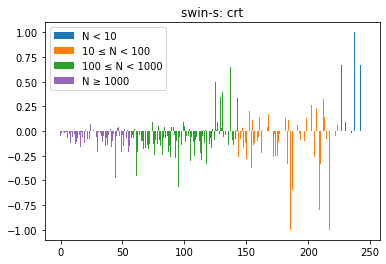

In [19]:
plot_f1(wcs_results, wcs_instances_per_cls, 'swin-s', 'crt', 'repre')

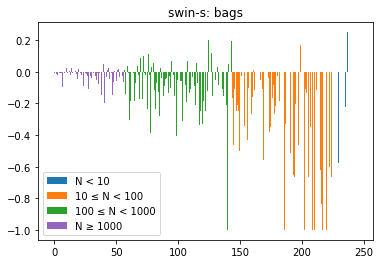

In [20]:
plot_f1(wcs_results, wcs_instances_per_cls, 'swin-s', 'bags', 'repre')

### Seregeti

In [21]:
serengeti_results = results[results.dataset=='serengeti']
serengeti_instances_per_cls = load_instances_per_class('/data/fagner/training/bags_paper/data/snapshot_serengeti_images_20211210ufam_train.json')

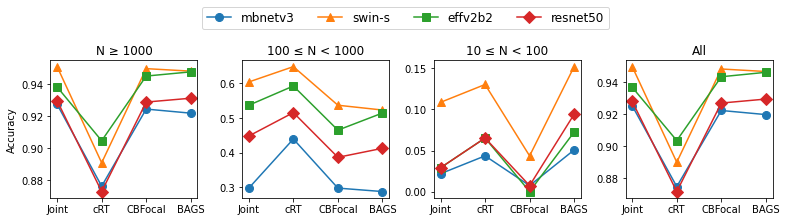

In [22]:
plot_all_bins_acc(serengeti_results)

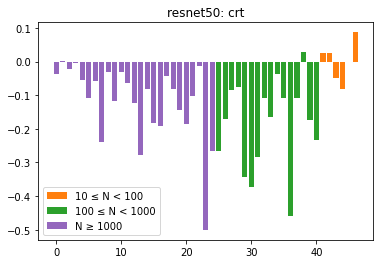

In [23]:
plot_f1(serengeti_results, serengeti_instances_per_cls, 'resnet50', 'crt', 'repre')

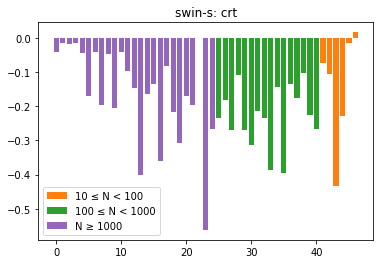

In [24]:
plot_f1(serengeti_results, serengeti_instances_per_cls, 'swin-s', 'crt', 'repre')

### Caltech

In [25]:
caltech_results = results[results.dataset=='caltech']
caltech_instances_per_cls = load_instances_per_class('/data/fagner/training/bags_paper/data/caltech_images_20211210ufam_train.json')

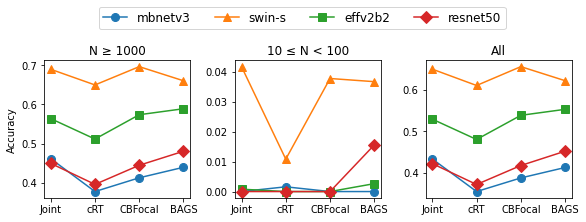

In [26]:
plot_all_bins_acc(caltech_results)

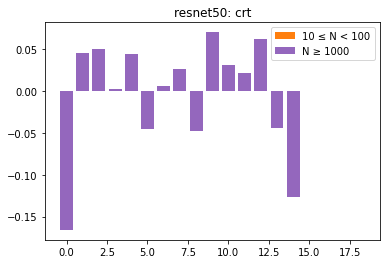

In [27]:
plot_f1(caltech_results, caltech_instances_per_cls, 'resnet50', 'crt', 'repre')

### Wellington

In [28]:
wellington_results = results[results.dataset=='wellington']
wellington_instances_per_cls = load_instances_per_class('/data/fagner/training/bags_paper/data/wellington_images_20211210ufam_train.json')

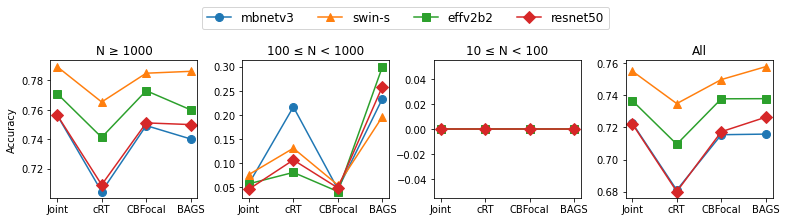

In [29]:
plot_all_bins_acc(wellington_results)

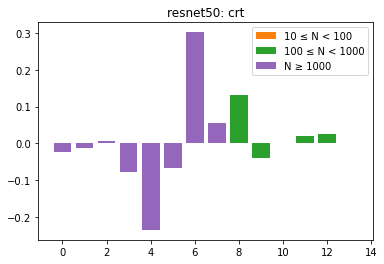

In [30]:
plot_f1(wellington_results, wellington_instances_per_cls, 'resnet50', 'crt', 'repre')